In [1]:
import ipywidgets.widgets as widgets
controller = widgets.Controller(index=0)  #Replace with the index number of the controller you just tested
display(controller)

Controller()

In [2]:
#Import function library path
from servoserial import ServoSerial
from jetbot import Robot
import traitlets
from jetbot import Camera
from jetbot import Heartbeat
import threading
import time
# Thread function operation library
import inspect
import ctypes

import traitlets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
import os
from uuid import uuid1
import cv2
import numpy as np
from RGB_Lib import Programing_RGB
RGB = Programing_RGB()

In [14]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA Tegra X1'

In [7]:
torch.cuda.device(0)

In [8]:
device = torch.device('cuda')

In [3]:
camera = Camera.instance(width=224, height=224)

In [5]:
image = widgets.Image(format='jpeg', width=224, height=224)  # this width and height doesn't necessarily have to match the camera
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [6]:
def handle_heartbeat_status(change):
    if change['new'] == Heartbeat.Status.dead:
        camera_link.unlink()
        robot.stop()

heartbeat = Heartbeat(period=0.5)
# Append the callback function to the heartbeat state
heartbeat.observe(handle_heartbeat_status, names='status')

In [7]:
def _async_raise(tid, exctype):
    """raises the exception, performs cleanup if needed"""
    tid = ctypes.c_long(tid)
    if not inspect.isclass(exctype):
        exctype = type(exctype)
    res = ctypes.pythonapi.PyThreadState_SetAsyncExc(tid, ctypes.py_object(exctype))
    if res == 0:
        raise ValueError("invalid thread id")
    elif res != 1:
        # """if it returns a number greater than one, you're in trouble,
        # and you should call it again with exc=NULL to revert the effect"""
        ctypes.pythonapi.PyThreadState_SetAsyncExc(tid, None)
        
def stop_thread(thread):
    _async_raise(thread.ident, SystemExit)

In [11]:
'''Servo Part'''
servo_device = ServoSerial() 
def camUpFunction():
    global updownpulse
    updownpulse+=15
    if updownpulse>4095:
        updownpulse=4095
    servo_device.Servo_serial_control(2, updownpulse)

def camDownFunction():
    global updownpulse
    updownpulse-=15
    if updownpulse<1300:
        updownpulse=1300
    servo_device.Servo_serial_control(2, updownpulse)

def camLeftFunction():
    global leftrightpulse
    leftrightpulse+=15
    if leftrightpulse>3600:
        leftrightpulse=3600
    servo_device.Servo_serial_control(1, leftrightpulse)

def camRightFunction():
    global leftrightpulse
    leftrightpulse-=15
    if leftrightpulse<600:
        leftrightpulse=600
    servo_device.Servo_serial_control(1, leftrightpulse)

def camservoInitFunction():
    global leftrightpulse, updownpulse
    leftrightpulse = 2048
    updownpulse = 2048
    servo_device.Servo_serial_control(1, 2048)
    time.sleep(0.1)
    servo_device.Servo_serial_control(2, 2048)

serial Open!
serial Close!


In [9]:
camservoInitFunction()

184
b'\xff\xff\x01\x07\x03*\x08\x00\x00\n\xb8'
183
b'\xff\xff\x02\x07\x03*\x08\x00\x00\n\xb7'


In [10]:
robot = Robot()

In [150]:
def kmeans(X, k, max_iters=100):
    # 데이터 포인트의 수와 특성의 수 확인
    m, n = X.shape

    # 초기 중심 선택
    centroids = X[np.random.choice(m, k, replace=False)]
    for _ in range(max_iters):
        # 각 데이터 포인트에 대해 가장 가까운 중심 찾기
        distances = torch.norm(X[:, None] - centroids, dim=2)
        labels = torch.argmin(distances, dim = 1)

        # 중심 재계산
        new_centroids =[X[labels == j].mean(dim=0) for j in range(k)]

        # 수렴 여부 확인
        print(centroids.int(), new_centroids)
        if np.all(list(centroids.int()) == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

In [151]:
a = torch.tensor(camera.value,dtype = torch.float32 ,device = device).reshape(-1, 3)

In [152]:
center_color, labels = kmeans(a,5)
center_color

tensor([[ 38,  32,  27],
        [126, 149, 164],
        [ 27,  34,  43],
        [ 97,  94,  88],
        [159, 158, 165]], device='cuda:0', dtype=torch.int32) [<built-in method values of Tensor object at 0x7eb580f438>, <built-in method values of Tensor object at 0x7eb57eebd0>, <built-in method values of Tensor object at 0x7eb580fb88>, <built-in method values of Tensor object at 0x7eb580f6c0>, <built-in method values of Tensor object at 0x7eb580fb40>]


TypeError: eq() received an invalid combination of arguments - got (builtin_function_or_method), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: (!builtin_function_or_method!)
 * (Number other)
      didn't match because some of the arguments have invalid types: (!builtin_function_or_method!)


In [ ]:
center_color, labels = kmeans(camera.value, 5)
center_color

In [12]:
def BLN_Onboard():
    while 1:
        frame = camera.value
        
#         hsv_frame = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
#         value = hsv_frame[:,:,2]
#         value = value
#         hsv_frame[:,:,2] = value
#         rgb_frame = cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR)
#         rgb_frame[:,:,0]
        
        blue_hist = cv2.calcHist([frame],[0],None,[256],[0,256])
        grean_hist = cv2.calcHist([frame],[1],None,[256],[0,256])
        red_hist = cv2.calcHist([frame],[2],None,[256],[0,256])
        
        #b = frame.mean(axis=0).mean(axis=0).astype('int')
        #hex_b = np.vectorize(hex)(b)
        
        #rgb = np.array([red_hist.argmax(),grean_hist.argmax(),blue_hist.argmax()])
        
        RGB.Set_All_RGB(red_hist.argmax(),grean_hist.argmax(),blue_hist.argmax())

In [23]:
blue_hist = cv2.calcHist([camera.value],[0],None,[256],[0,256])
green_hist = cv2.calcHist([camera.value],[1],None,[256],[0,256])
red_hist = cv2.calcHist([camera.value],[2],None,[256],[0,256])

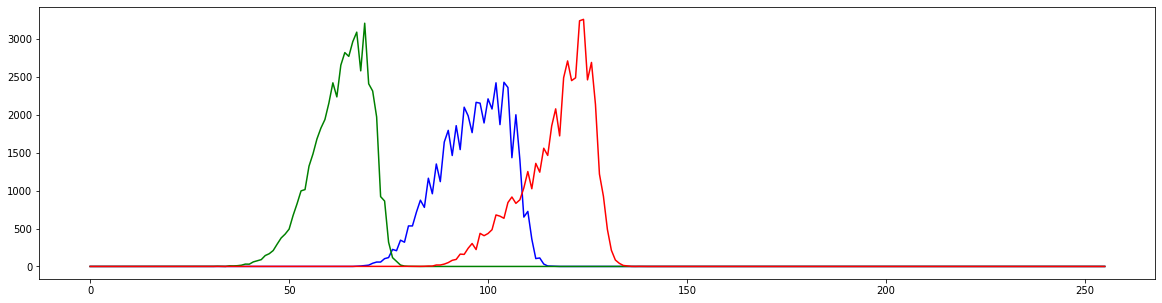

In [30]:
plt.figure(figsize=(20,5))
plt.plot(blue_hist, 'b-')
plt.plot(green_hist, 'g-')
plt.plot(red_hist, 'r-')

In [13]:
thread1 = threading.Thread(target=BLN_Onboard)
# thread1.setDaemon(True)
thread1.start()

In [6]:
stop_thread(thread1)

NameError: name 'stop_thread' is not defined

In [14]:
RGB.OFF_ALL_RGB()

In [14]:
def jetbot_motion():
    count1 = count2 = count3 = count4 =  count5 = 0
    while 1:
        
        if controller.axes[1].value <= 0.1:
            if (controller.axes[0].value <= 0.1 and controller.axes[0].value >= -0.1 
                and controller.axes[1].value <= 0.1 and controller.axes[1].value >= -0.1):
                robot.stop()
            else:
                robot.set_motors(-controller.axes[1].value + controller.axes[0].value, -controller.axes[1].value - controller.axes[0].value)
            
            time.sleep(0.01)
        else:
            robot.set_motors(-controller.axes[1].value - controller.axes[0].value, -controller.axes[1].value + controller.axes[0].value)
            time.sleep(0.01)
        if controller.axes[3].value == 1:
            count1  += 1
            if count1 >= 3:
                camDownFunction()
                count1 = 0
        elif controller.axes[3].value == -1:
            count1  += 1
            if count1 >= 3:
                camUpFunction()
                count1 = 0
        else:
            count1 = 0
        if controller.axes[2].value == 1:
            count2  += 1
            if count2 >= 3:
                camRightFunction()
                count2 = 0
        elif controller.axes[2].value == -1:
            count2  += 1
            if count2 >= 3:
                camLeftFunction()
                count2 = 0
        else:
            count2 = 0
        #Servo control camera up down, left and right is reset
        if controller.buttons[8].value == True:
            count3 += 1
            if count3 >= 3:
                camservoInitFunction()
                count3 = 0
        else:
            count3 = 0
        
        #Servo control servo rise and decline
        if controller.buttons[6].value == True:
            count4 += 1
            if count4 >= 3:
                robot.set_vertical_motors(1)
                count4 = 0
        elif controller.buttons[4].value == True:
            count4 += 1
            if count4 >= 3:
                robot.set_vertical_motors(-1)
                count4 = 0
        else:
            robot.set_vertical_motors(0)
            count4 = 0

In [15]:
thread2 = threading.Thread(target=jetbot_motion)
thread2.setDaemon(True)
thread2.start()

In [ ]:
stop_thread(thread1)

In [ ]:
stop_thread(thread2)

In [ ]:
RGB.OFF_ALL_RGB()